In [46]:
library(dplyr)
library(ggplot2)
library(tidyr)

In [4]:
permutate_0DPA=read.table(
    "./eQTL_noise_check/0DPA_permutate.txt",
    header=F,sep="\t"
    )
for(stage in c("4DPA","8DPA","12DPA","16DPA","20DPA")){
    tmpData=read.table(
    paste(
        "./eQTL_noise_check/",stage,"_permutate.txt",sep=""
    ),
    header=F,sep="\t"
    )
    permutate_0DPA=rbind(permutate_0DPA,tmpData)
}

In [8]:
#*
plotData=permutate_0DPA[,2:101] %>% pivot_longer(
    cols = starts_with('V'),
    names_to = 'valueType',
    values_to = 'permutateVal'
) %>% mutate(valueType='permutated')

In [5]:
observedData=permutate_0DPA %>% mutate(permutateVal=V1,valueType='observed') %>% select(
        c('permutateVal','valueType')
)

In [12]:
#-------------------------------------
#* 随机筛选5000个permutate数据
#-------------------------------------
selectData=plotData[sample(nrow(plotData),5000),] 
MergeData=rbind(observedData,selectData)

In [16]:
#-----------------------------------------------------------------
# TODO 将permutate得到的随机的结果统计发生频率
#-----------------------------------------------------------------
MergeData$difflevel <- as.numeric(
    as.character(as.vector(
        cut(
            MergeData$permutateVal,
            breaks = c(-Inf, seq(-10, 10, 0.1), Inf),
            labels = seq(-10, 10.1, 0.1),
            right = T,
            left = T
        )
    ))
)

In [23]:
observedPlotData=MergeData %>% filter(valueType=="observed") %>% count(difflevel) %>% mutate(valueType="observed")
permutatePlotData=MergeData %>% filter(valueType!="observed") %>% count(difflevel) %>% mutate(valueType="permutate")

png 
  2

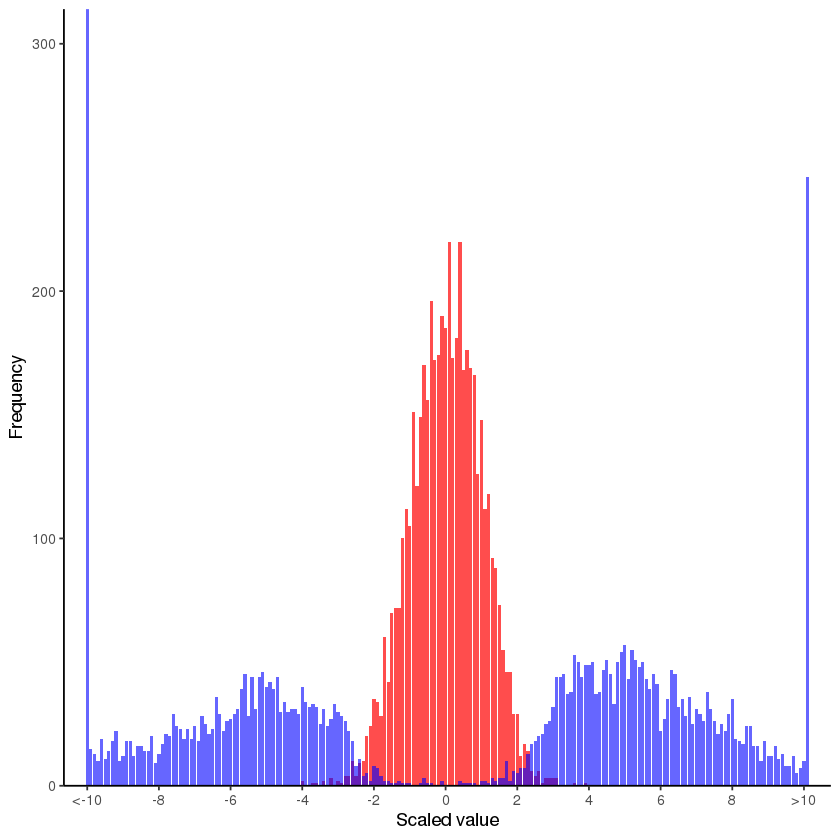

In [45]:
p <- permutatePlotData %>% ggplot(aes(x = difflevel, y = n)) +
    geom_bar(
        stat = "identity",
        fill = "red",
        alpha = 0.7
    ) +
    geom_bar(
        data = observedPlotData,
        aes(x = difflevel, y = n),
        stat = "identity",
        inherit.aes = FALSE,
        fill = "blue",
        alpha = 0.6
    ) +
    scale_x_continuous(
        expand = c(0.03, 0),
        breaks = seq(-10, 10, 2),
        labels = c("<-10", seq(-8, 8, 2), ">10")
    ) +
    theme_classic() +
    scale_y_continuous(expand = c(0, 0)) +
    ylab("Frequency") +
    xlab("Scaled value")
pdf("expression_noise.pdf")
print(p)
dev.off()
p

In [56]:
#----------------------------------------------------------
#TODO 检测fake eQTL所对应的样本表达分布
#----------------------------------------------------------
fake_Gene_expression=read.table(
    "./eQTL_noise_check/fake_eQTL_sampleExpression.txt",header=T,sep="\t"
    )
confidence_Gene_expression=read.table(
    "./eQTL_noise_check/confidence_eQTL_sampleExpression.txt",header=T,sep="\t"
    )
confidence_Gene_expression$eQTLType='confidence'
fake_Gene_expression$eQTLType='fake'

In [60]:
plotData=rbind(confidence_Gene_expression,fake_Gene_expression)

png 
  2

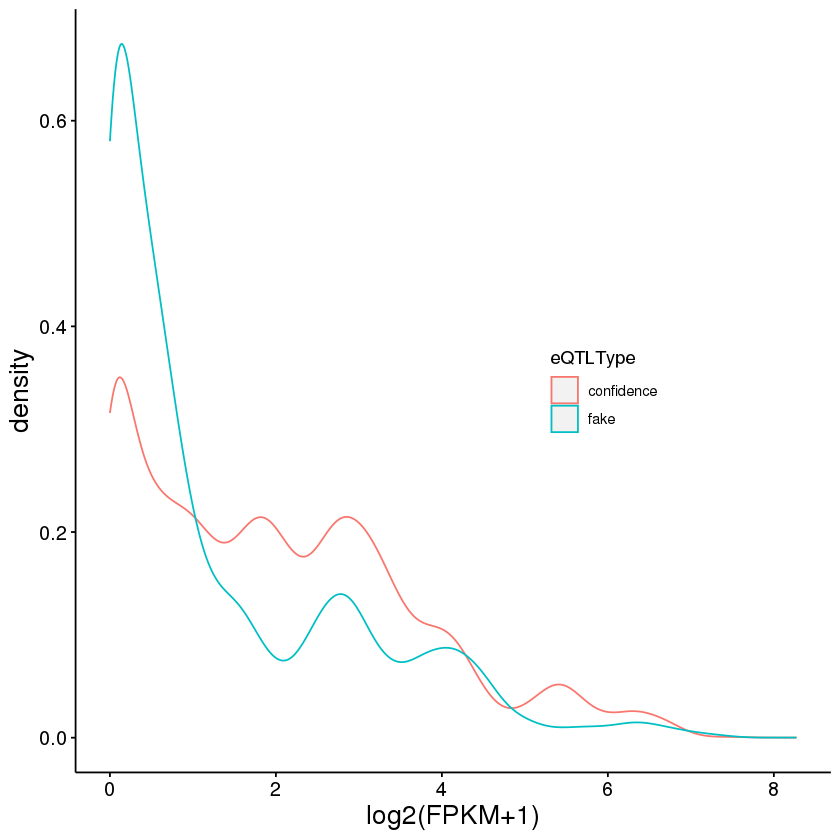

In [66]:
p=plotData %>% ggplot(
    aes(x = log2(expression + 1),color=eQTLType)
    ) +
    geom_density()+
    theme(
        panel.grid = element_blank(),
        panel.background = element_blank(),
        legend.position = c(0.7,0.5)
    )+
    base_theme+
    xlab("log2(FPKM+1)")
pdf("noise_gene_expression.pdf")
print(p)
dev.off()
p